In [27]:
# -*- pecanns -*-
"""
Author: Shamsulhaq Basir
Date  : June 20, 2022
"""
import argparse
import time
import os
import torch
import torch.nn as nn
import numpy as np
from numpy import vectorize
from tqdm import tqdm

from torch.optim import LBFGS,Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float64)
dtype  = torch.float64

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import matplotlib as mpl
from matplotlib import ticker

In [28]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net = nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 
    def forward(self, x):
        out = self.net(x)
        return out 
    
    
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out  = self.net(data)
        u    = out[:,0].reshape(-1,1)
        v    = out[:,1].reshape(-1,1)
        p    = out[:,2].reshape(-1,1)
        w    = out[:,3].reshape(-1,1)
        return u,v,p,w
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)   

In [385]:
domain   = np.array([[0.,0.],[1.0, 1.0]])
kwargs ={"mean":torch.tensor([[0.5, 0.5]]), "stdev":torch.tensor([[0.2887, 0.2887]])}   

layers = [2,20,20,20,20,20,20,4]
model  = Network(layers,**kwargs)
#model.load_state_dict(torch.load("models/Navier_Stokes_Flow_20000.pt")) #2500 lrm2
model.load_state_dict(torch.load("models_lrm2/Navier_Stokes_Flow_20000.pt"))
print(model)
print(model.mu.shape)
print(model.stdev.shape)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (4): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (5): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)
torch.Size([1, 2])
torch.Size(

In [408]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels
    'axes.titlesize': 14,
    'font.size'     : 14, 
    'legend.fontsize': 14, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [4, 4],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

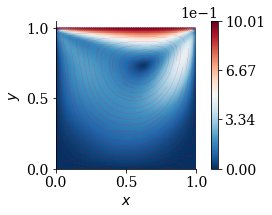

In [418]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])

x = torch.linspace(0,1,64)
y = torch.linspace(0,1,64)

x,y = torch.meshgrid(x,y,indexing='xy')

up,vp,_,_ = model(x.reshape(-1,1),y.reshape(-1,1))

up = up.reshape(x.shape)
vp = vp.reshape(x.shape)

velocity = (up.detach().pow(2) + vp.detach().pow(2)).sqrt()

pimg=plt.pcolormesh(x.numpy(),y.numpy(),
                    velocity,cmap=cmap,
                    shading='gouraud',
                    vmin=torch.amin(velocity),
                    vmax=torch.amax(velocity))

colorbar(pimg,min_val = torch.amin(velocity),max_val= torch.amax(velocity),limit=-1)



x = torch.linspace(0,1,64)
y = torch.linspace(0,1,64)

x,y = torch.meshgrid(x,y,indexing='xy')
up,vp,_,_ = model(x.reshape(-1,1),y.reshape(-1,1))

up = up.reshape(x.shape)
vp = vp.reshape(x.shape)

plt.streamplot(x.numpy(),y.numpy(),
                  up.detach().numpy(),
                  vp.detach().numpy(),
                  density=1,
                  arrowsize=0.1,
                  arrowstyle='->',
                  color='r',
                  linewidth=0.1,
                  cmap=cmap)
ax.axis('scaled')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
plt.savefig('figures/predicted_NS_velocity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

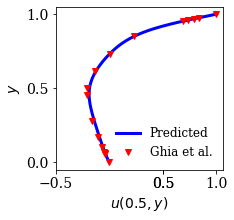

In [419]:
fig = plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])

y = []
u = []
with open('ghiau.txt') as f:
    while True:
        line = f.readline()
        if not line: 
            break
        line = line.strip()
        y.append(float(line.split()[0]))
        u.append(float(line.split()[1]))
        
y = torch.tensor(y).reshape(-1,1)
x = torch.full_like(y,0.5)
u = torch.tensor(u).reshape(-1,1)

# prediction from the model
y_ = torch.linspace(0,1,256)[:,None]
x_ = torch.full_like(y_,0.5)
up,_,_,_ = model(x_,y_)

ax.plot(up.detach(),y_,"b",linewidth=3,label='Predicted')
ax.plot(u,y,'vr',linewidth=3,label="Ghia et al.")
ax.set_xlabel('$u(0.5,y)$')
ax.set_ylabel('$y$')
ax.set_yticks([0,0.5,1])
ax.set_xticks([-0.5,0.5,0.5,1])
ax.legend(frameon=False,fontsize=12)
plt.savefig('figures/verification_NS_horizontal_velocity.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

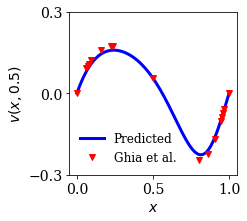

In [420]:
fig = plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])


# model
x = torch.linspace(0,1,256)[:,None]
y = torch.full_like(x,0.5)
_,vp,_,_ = model(x,y)

ax.plot(x,vp.detach(),"b",linewidth=3,label="Predicted")


x = []
v = []
with open('ghiav.txt') as f:
    while True:
        line = f.readline()
        if not line: 
            break
        line = line.strip()
        x.append(float(line.split()[0]))
        v.append(float(line.split()[1]))
        
x = torch.tensor(x)
v = torch.tensor(v)

ax.plot(x,v,'vr',label='Ghia et al.')

ax.set_xlabel('$x$')
ax.set_ylabel('$v(x,0.5)$')
ax.set_yticks([-0.3,0,0.3])
ax.set_xticks([-0,0.5,1.0])
ax.legend(frameon=False,fontsize=12)
plt.savefig('figures/verification_NS_vertical_velocity.png',bbox_inches='tight', pad_inches=0.1)
plt.show()